In [1]:
# import packages
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from skimage.segmentation import mark_boundaries
import math 
import lime.lime_image as li

In [80]:
# import custom functions
import sys
sys.path.append('../src')

from data_functions import *

In [11]:
# get paths from base directory
base_dir = 'D:/MRI_data/Kaggle'
absent_paths, present_paths = get_img_paths(base_dir)

In [13]:
len(present_paths)

2919

In [14]:
# define train size for data set
train_size = 0.8 # eighty percent
test_size = 0.15 # fifteen percent
val_size = 0.05 # five percent

# calculate test size for second split
test_size2 = test_size/(1-train_size)

# split absent paths into train and test
absent_train, absent_test = train_test_split(absent_paths, train_size=train_size, random_state=2021)

# split absent test paths into test and validation
absent_test, absent_val = train_test_split(absent_test, train_size=test_size2, random_state=2021)

# split present paths into train and test
present_train, present_test = train_test_split(present_paths, train_size=train_size, random_state=2021)

# split present paths into test and val
present_test, present_val = train_test_split(present_test, train_size=test_size2, random_state=2021)

In [15]:
# combine train and test and validation lists (respectively)
train = absent_train
train.extend(present_train)

test = absent_test
test.extend(present_test)

val = absent_val
val.extend(present_val)

In [16]:
# load image data
train_img_data = get_data(train)

val_img_data = get_data(val)

test_img_data = get_data(test)

In [17]:
# remove duplicates from each set
unique_train_img, train_duplicate = remove_duplicates(train_img_data)
unique_val_img, val_duplicate = remove_duplicates(val_img_data)
unique_test_img, test_duplicate = remove_duplicates(test_img_data)

duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[27 27 27]] and [[27 27 27]]
duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[15 15 15]] and [[15 15 15]]
duplicate found:[[16 16 16]] and [[16 16 16]]
duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[30 30 30]] and [[30 30 30]]
duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[15 15 15]] and [[15 15 15]]
duplicate found:[[39 39 39]] and [[39 39 39]]
duplicate found:[[1 1 1]] and [[1 1 1]]
duplicate found:[[20 20 20]] and [[20 20 20]]
duplicate found:[[20 20 20]] and [[20 20 20]]
duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[1 1 1]] and [[1 1 1]]
duplicate found:[[0 0 0]] and [[0 0 0]]
duplicate found:[[14 14 14]] and [[14 14 14]]
duplicate found:[[1 1 1]] and [[1 1 1]]
duplicate found:[[10 10 10]] and [[10 10 10]]
duplicate found:[[7 

(-0.5, 149.5, 149.5, -0.5)

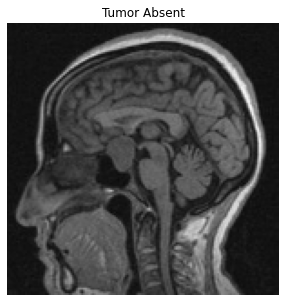

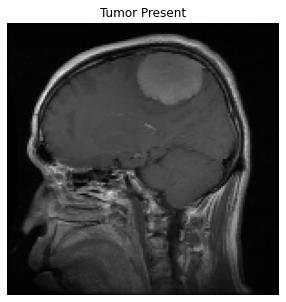

In [45]:
labels = ['Tumor Absent', 'Tumor Present']
# plot image data from first [1] train image data (tumor-free brain)
plt.figure(figsize=(5,5))
plt.imshow(unique_train_img[100][0], cmap='gray')
plt.title(labels[unique_train_img[100][1]])
plt.axis('off')

# plot image data from last [-1] train image data (tumor patient brain)
plt.figure(figsize=(5,5))
plt.imshow(unique_train_img[-22][0], cmap='gray')
plt.title(labels[unique_train_img[-22][1]])
plt.axis('off')

In [46]:
# separate image data and identifiers
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for data, label, _ in unique_train_img:
    x_train.append(data)
    y_train.append(label)
    
for data, label, _ in unique_val_img:
    x_val.append(data)
    y_val.append(label)
    
for data, label, _ in unique_test_img:
    x_test.append(data)
    y_test.append(label)

In [58]:
# scale data and convert to np.array for efficiency

x_train = np.array(x_train)/255

x_test = np.array(x_test)/255

x_val = np.array(x_val)/255

In [59]:
img_size = 150

# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 3)

x_test = x_test.reshape(-1, img_size, img_size, 3)

x_val = x_val.reshape(-1, img_size, img_size, 3)

In [60]:
datagen = ImageDataGenerator(\
                            featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False, 
                            zca_whitening=False, 
                            rotation_range=30,
                            zoom_range=0.25,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=False)

In [65]:
metrics = ['Recall', 'accuracy']
learning_rate_reduction_loss = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_lr=10**-9)
learning_rate_reduction_acc = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=10**-9)

model= Sequential()
model.add(Conv2D(32, (3,3), strides =1, padding = 'same', activation ='relu', input_shape = (150,150,3)))

model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (2,2), strides =1, padding ='same', activation='relu'))
model.add(Dropout(0.15))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (3,3), strides =1, padding ='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (3,3), strides =1, padding ='same', activation='selu'))


model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=metrics)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 38, 38, 64)        36928     
_________________________________________________________________
dropout_7 (Dropout)          (None, 38, 38, 64)       

In [66]:
epochs = 12
model_history = model.fit(datagen.flow(x_train, y_train), epochs=epochs, validation_data=datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction_loss, learning_rate_reduction_acc])

Epoch 1/12
80/80 [==============================] - 69s 860ms/step - loss: 0.7876 - recall: 0.9821 - accuracy: 0.8449 - val_loss: 0.4728 - val_recall: 1.0000 - val_accuracy: 0.8343
Epoch 2/12
80/80 [==============================] - 75s 942ms/step - loss: 0.4033 - recall: 0.9977 - accuracy: 0.8579 - val_loss: 0.4257 - val_recall: 1.0000 - val_accuracy: 0.8343
Epoch 3/12
80/80 [==============================] - ETA: 0s - loss: 0.5235 - recall: 0.9881 - accuracy: 0.8516
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
80/80 [==============================] - 64s 802ms/step - loss: 0.5235 - recall: 0.9881 - accuracy: 0.8516 - val_loss: 0.4211 - val_recall: 1.0000 - val_accuracy: 0.8343
Epoch 4/12
80/80 [==============================] - 64s 804ms/step - loss: 0.3198 - recall: 1.0000 - accuracy: 0.8591 - val_loss: 0.3660 - val_recall: 1.0000 - val_accuracy: 0.8343
Epoch 5/12
80/80 [==============================] - 68s 850ms/step - loss: 0.3002 - recall: 0.99

# Visualize Performance

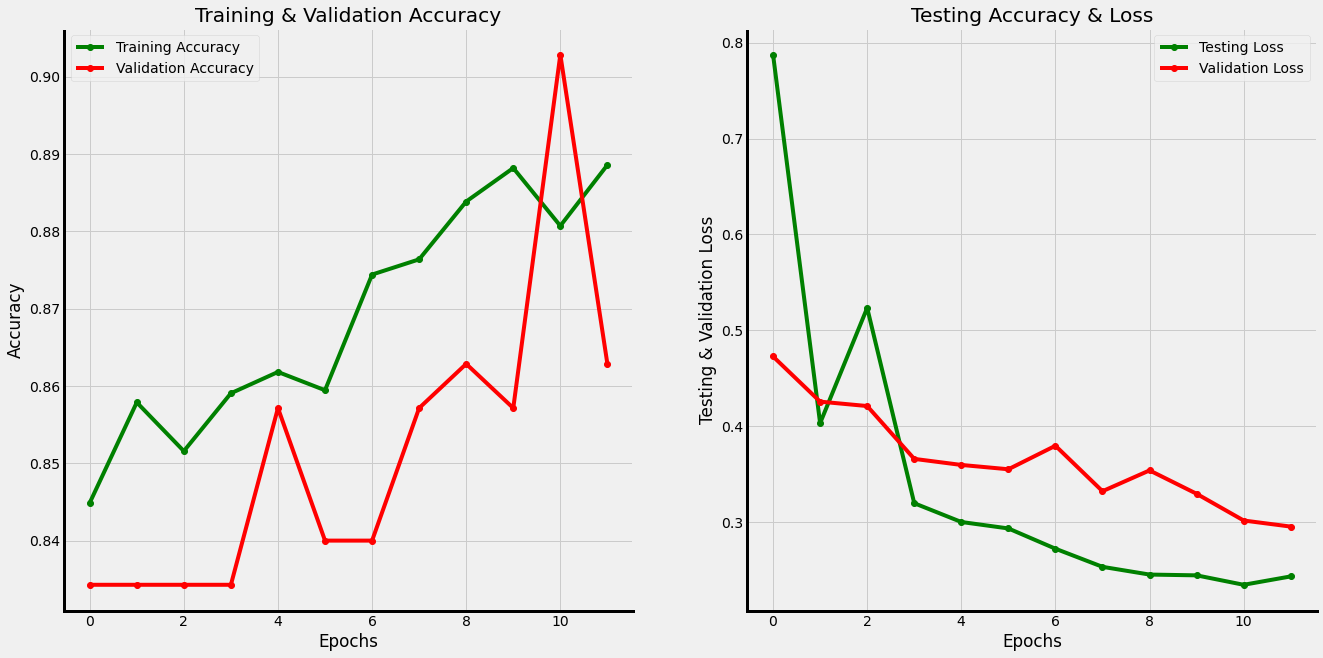

In [74]:
plot_metrics(model.history, filename='final')

              precision    recall  f1-score   support

    No Tumor       0.60      0.63      0.61        81
       Tumor       0.93      0.92      0.93       429

    accuracy                           0.87       510
   macro avg       0.76      0.78      0.77       510
weighted avg       0.88      0.87      0.88       510

[[ 51  30]
 [ 34 395]]


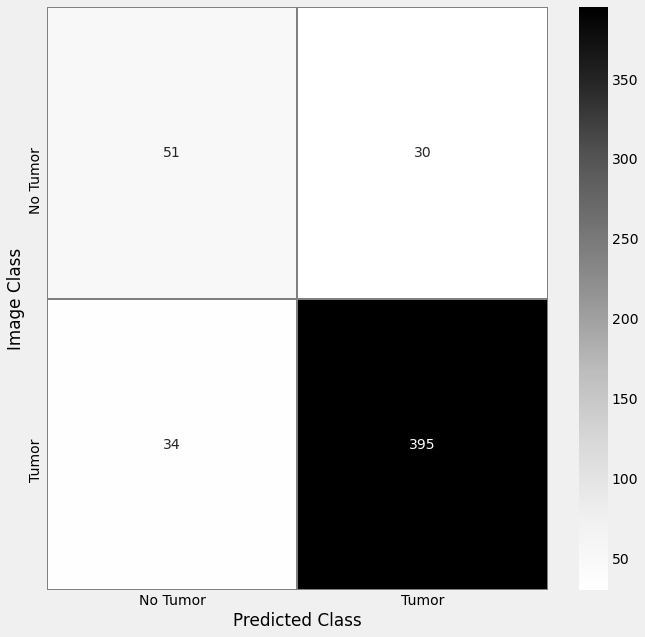

In [81]:
plot_confusion_matrix(model, x_test, y_test, filename='final')

# Analyze Model

In [90]:
# get model predictions
predictions = (model.predict(x_test) > 0.5).astype('int32')
# identify image classifications
good_preds0 = []
good_preds1 = []
type_1 = []
type_2 = []

for i in range(len(y_test)):
    
    if y_test[i] == predictions[i]:
        if y_test[i] == 0:
            good_preds0.append(i)
        
        else:
            good_preds1.append(i)
    
    elif y_test[i] == 1:
        type_1.append(i)
        
    else:
        type_2.append(i)
        
good_preds0 = np.array(good_preds0)
good_preds1 = np.array(good_preds1)
type_1 = np.array(type_1)
type_2 = np.array(type_2)

## TIME for LIME

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


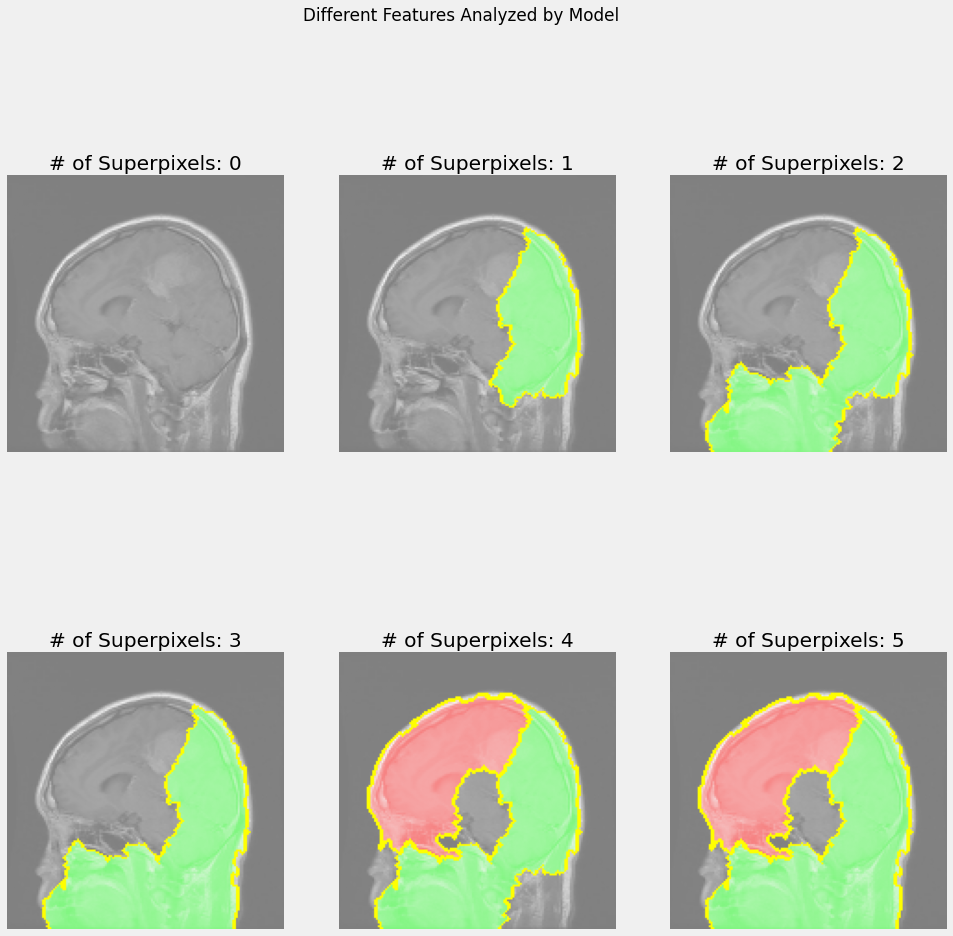

In [103]:
# analyze correctly identified image
lime_image(model, x_test[good_preds1[2]], min_superpixels=0, max_superpixels=6, filename='tumor_correct[2]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


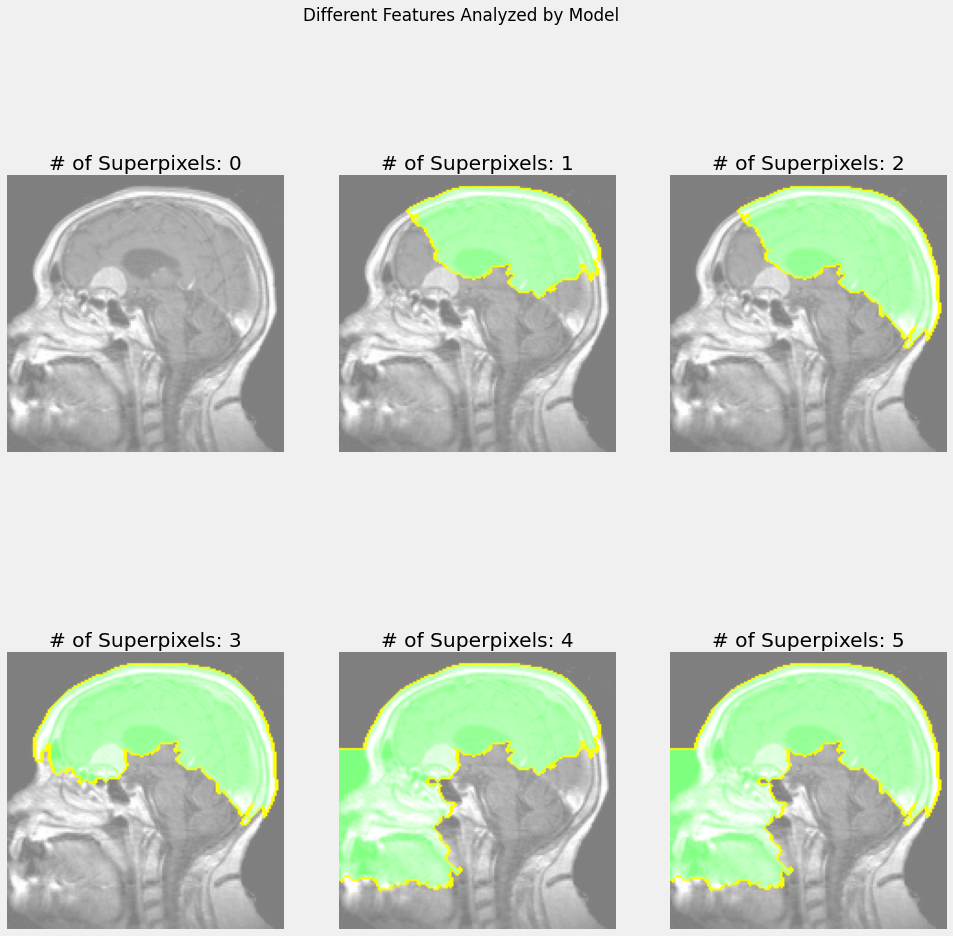

In [104]:
lime_image(model, x_test[good_preds1[3]], min_superpixels=0, max_superpixels=6, filename='tumor_correct[3]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


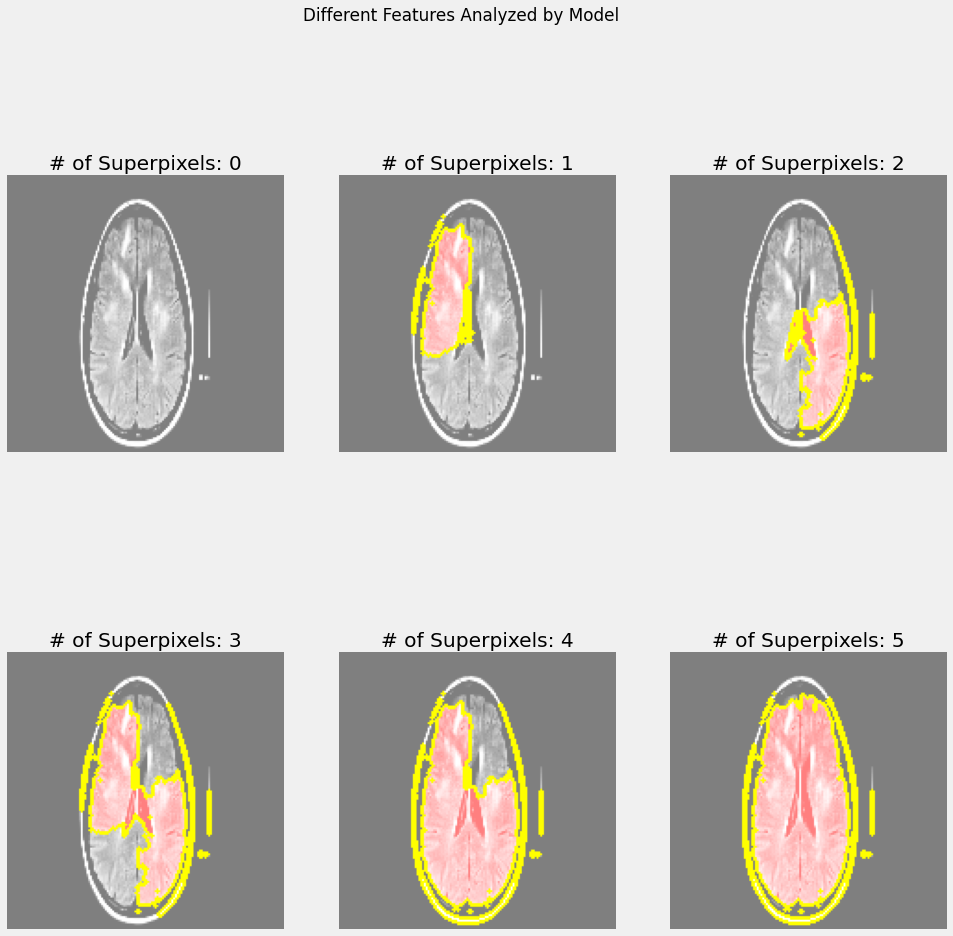

In [105]:
lime_image(model, x_test[good_preds0[0]], min_superpixels=0, max_superpixels=6, filename='no_tumor_correct[0]')

In [ ]:
lime_image(model, x_test[type_1[0]], min_superpixels=0, max_superpixels=6, filename='type_1_error[0]')

rows: 2  columns: 3
len(ax) = 2
m_end: 3  n_end: 0


In [ ]:
lime_image(model, x_test[type_1[1]], min_superpixels=0, max_superpixels=6, filename='type_1_error[1]')

In [ ]:
lime_image(model, x_test[type_2[0]], min_superpixels=0, max_superpixels=6, filename='type_2_error[0]')

In [ ]:
lime_image(model, x_test[type_2[1]], min_superpixels=0, max_superpixels=6, filename='type_2_error[1]')